# Coupling rainfall-runoff-soil infiltration depth in Landlab

<hr>
<small>For more Landlab tutorials, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html</a></small>
<hr>

# Overview of notebook
In this notebook we will explore how incorporating a soil infiltration component (`SoilInfiltrationGreenAmpt`) to the **Coupled rainfall-runoff model with OverlandFlow** tutorial affects stream outlet stage height. Additionally, we can test how varying storm parameters in `PrecipitationDistribution` modify our results. 

### Components needed to run model
`PrecipitationDistribution`
`OverlandFlow`
`SoilInfiltrationGreenAmpt`

# Conceptual Model

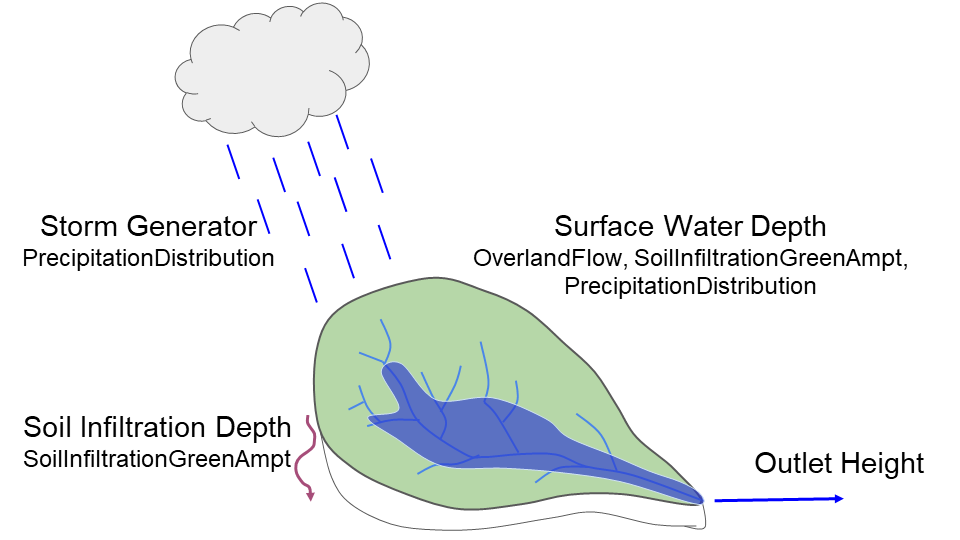


#### Step 1
Using the `PrecipitationDistribution` component in Landlab we will generate a single storm that is uniform in space, but varies in rainfall flux over the duration of the storm. This will be done on a simple catchment (`hugo_site.asc`). Rainfall flux will contribute to `surface_water_depth` which will be fed into `soil_water_infiltration__depth`.

#### Step 2
With the `SoilInfiltrationGreenAmpt`, we will calculate the `soil_water_infiltration__depth` and the new `surface_water__depth`. 

#### Step 3
This `surface_water__depth` term is also used in `OverlandFlow`! So now we can run the `OverlandFlow` to determine where (and how much) the water goes. 



### First, we import what we need

In [2]:
import numpy as np
from landlab.io import read_esri_ascii
from landlab import imshow_grid_at_node
from landlab.components import OverlandFlow
import matplotlib.pyplot as plt
from landlab.components import SoilInfiltrationGreenAmpt
from landlab.components.uniform_precip import PrecipitationDistribution
import random

### Then set up for the model run

Q1 - How does different rainfall events regulates depth of the water front entering the soil during a storm ?

--> change the parameters of the rainfall generator to observe how the duration of the storm, and the intensity impacts 
- the `soil_water_infiltration__depth`, which is the front of water entering the soil.
- the `surface_water__depth`, which is the water height flowing on the surface.

In [3]:
#Create the grid using topographique value from an asci file.
fname = 'hugo_site.asc'
mg, z = read_esri_ascii(fname, name='topographic__elevation')
mg.status_at_node[mg.nodes_at_right_edge] = mg.BC_NODE_IS_FIXED_VALUE
mg.status_at_node[np.isclose(z, -9999.)] = mg.BC_NODE_IS_CLOSED

#Define the parameter for rainfall generator
mean_duration = 2 #hours
mean_inter_duration = 10 #(h)
mean_storm_depth = 0.5 #(m) mean water heig
total_time  = 10 #(h)
delta_t = 1; # 
np.random.seed(np.arange(10)) #make sure that we are making the same random sequence everytime

#Generate the storm
precip = PrecipitationDistribution(mg, mean_storm_duration=mean_duration, mean_interstorm_duration=mean_inter_duration, mean_storm_depth=mean_storm_depth, total_t=total_time,delta_t=delta_t)
n = 5 #seed number, a certain seed gives a specific storm for the chosen parameters ##random.randint(1,101) #random number for stochastic results.
precip.seed_generator(seedval=n) #

## Define parameters for the infiltration component

Q2 - How does the soil hydraulic conductivity impact stream discharge?

--> change the hydraulic conductivity between 1e-5 and 1e-7, and look at how it impacts the stream discharge.
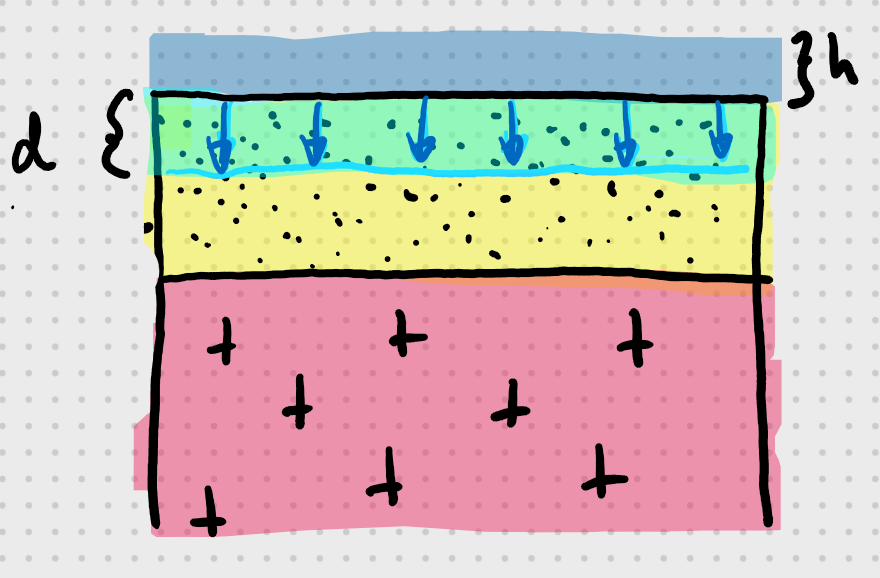

In [4]:
hydraulic_conductivity = mg.ones('node')*1e-6 #<<-- change this parameter to create more soil infiltration
h = mg.add_ones("surface_water__depth", at="node")
mg.at_node['surface_water__depth'].fill(1.e-12)  # a veneer of water stabilises the model
h *= 0.01
d = mg.add_ones("soil_water_infiltration__depth", at="node", dtype=float)
d *= 0.2

In [5]:
SI = SoilInfiltrationGreenAmpt(mg,hydraulic_conductivity=hydraulic_conductivity,soil_type='clay')
of = OverlandFlow(mg, steep_slopes=True)

### Loop through time

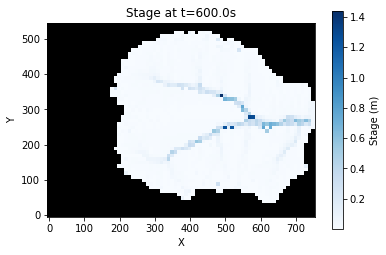

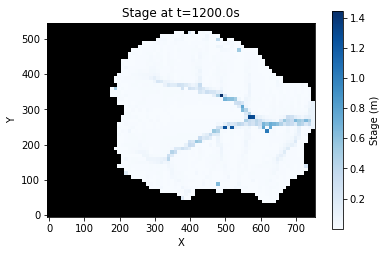

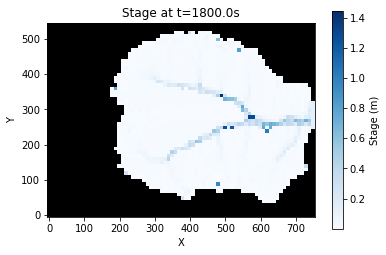

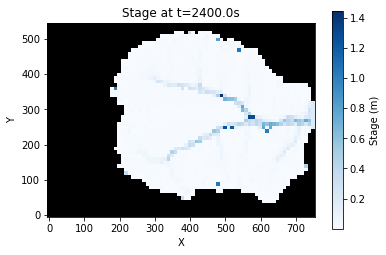

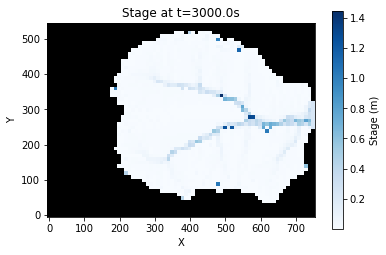

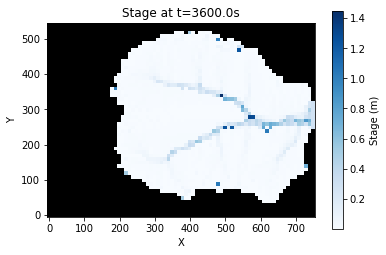

In [6]:
for (storm_t, interstorm_dt) in precip.yield_storms():
    
    node_of_max_q = 2126
    total_mins_to_plot = 60  # in minutes.
    plot_interval_mins = 10  
    min_tstep_val = 1.  # necessary to get the model going cleanly
    outlet_depth = [] 
    outlet_times = []
    storm_elapsed_time = 0
    total_elapsed_time = 0
    last_storm_loop_tracker = 0
    
    while total_elapsed_time < total_mins_to_plot * 60:
        dt = of.calc_time_step()
        remaining_total_time = total_mins_to_plot * 60 - total_elapsed_time
        if storm_elapsed_time < storm_t * 3600:
            remaining_storm_time = storm_t * 3600 - storm_elapsed_time
            dt = min((dt, remaining_total_time, remaining_storm_time, min_tstep_val))
        else:
            dt = min((dt, remaining_total_time, min_tstep_val))
        of.run_one_step(dt=dt)
        SI.run_one_step(dt=dt) 
        total_elapsed_time += dt
        storm_elapsed_time += dt
        storm_loop_tracker = total_elapsed_time % (plot_interval_mins * 60)
        
        if storm_loop_tracker < last_storm_loop_tracker:
            plt.figure()
            imshow_grid_at_node(
                mg,
                'surface_water__depth',
                var_name='Stage (m)',cmap ='Blues')
            plt.title('Stage at t=' + str(total_elapsed_time//1) + 's')
            plt.show()
        last_storm_loop_tracker = storm_loop_tracker
        outlet_depth.append(mg.at_node['surface_water__depth'][node_of_max_q])
        outlet_times.append(total_elapsed_time)
        if storm_elapsed_time < storm_t * 3600:
            mg.at_node['surface_water__depth'] += mg.at_grid['rainfall__flux'] * dt / 3600

Text(0.5, 1.0, 'Final infiltration depth')

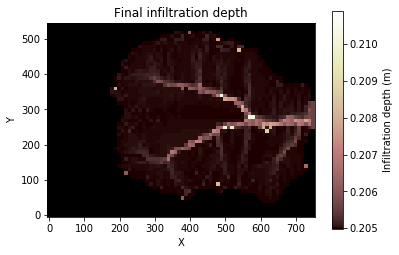

In [8]:
#Show final infiltration depth on grid

imshow_grid_at_node(mg,
                    values = 'soil_water_infiltration__depth',
                    plot_name = 'Infiltration depth',
                    var_name = 'Infiltration depth (m)')

plt.title('Final infiltration depth')

Text(0.5, 1.0, 'Final surface water depth')

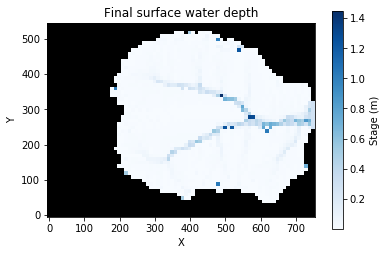

In [9]:
#Show final surface water depth on grid

imshow_grid_at_node(mg,
                    values = 'surface_water__depth',
                    var_name='Stage (m)',cmap ='Blues')

plt.title('Final surface water depth')


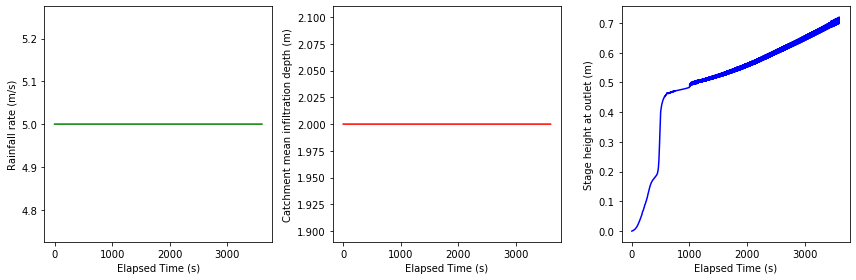

In [10]:
#Create 3 subplots to visualize:
#1. precipitation intensity (m/s) vs. time (s)
#2. catchment mean infiltration depth (m) vs. time (s)
#3. stage height at outlet (m) vs. time (s)


#initialize figure
fig, ax = plt.subplots(1,3, figsize = (12,4))

#subplot 0 - precip intensity vs time

##!!!!!!!!!!! Need a variable called rainfall_rate to be included in loop (similar to outlet depth)

rainfall_rate = np.zeros_like(np.asarray(outlet_depth)) + 5 #FAKE FOR NOW

ax[0].plot(outlet_times, rainfall_rate, color ='g')
ax[0].set_xlabel('Elapsed Time (s)')
ax[0].set_ylabel('Rainfall rate (m/s)')


#subplot 1 - catchment mean infiltration depth vs time

##!!!!!!!!!!!!! Need a variable called infil_depth to be included in loop (similar to outlet depth)
infil_depth = np.zeros_like(np.asarray(outlet_depth)) + 2  #FAKE FOR NOW

ax[1].plot(outlet_times, infil_depth, color = 'r')
ax[1].set_xlabel('Elapsed Time (s)')
ax[1].set_ylabel('Catchment mean infiltration depth (m)')


#subplot 2 - stage height at outlet vs time

ax[2].plot(outlet_times, outlet_depth, color = 'b')
ax[2].set_xlabel('Elapsed Time (s)')
ax[2].set_ylabel('Stage height at outlet (m)')

fig.tight_layout()